# Web Scrapping
#### Project: Extract feedback suggestions from Mutual website
#### Source: feedback.mutual.app
#### Monetization: Non-commercial use
#### Author: Pedro Sanhueza

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [2]:
# 12 seconds

page = 1
rows = []
rows_votes = []
rows_merged = []

while page:
    url = f'https://feedback.mutual.app/?page={page}&order=popular&filter=all#controls' # url for each page. only change the page number
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # List of dict: mulitple attributes
    info = soup.find_all('div',{'class':'sInfo'})
    for attribute in info:
        row = {}
        row['page'] = page
        row['id'] = attribute.find('a')['href'].split('/')[2]
        row['suggestion'] = attribute.find('a')['href'].split('/')[-1].replace('-',' ').capitalize()
        row['author'] = attribute.find_all('strong')[0].get_text()
        start = attribute.find_all('span')[0].get_text(strip=True).find('(')+1
        end = attribute.find_all('span')[0].get_text(strip=True).find(')')
        row['date_created'] = attribute.find_all('span')[0].get_text(strip=True)[start:end].replace('\'','20')
        try:
            row['last_upvoted'] = attribute.find_all('span',{'class':'sLastComment'})[0].get_text(strip=True)[9:]
        except:
            pass
        row['comments'] = attribute.find_all('span',{'class':'sLabel'})[0].get_text(strip=True)[10:]
        try:
            row['status'] = attribute.find_all('div',{'class':'sLabels'})[0].get_text(strip=True).replace('Pinned','')
        except:
            pass
        rows.append(row)

    # List of dict: 'votes' attribute
    votes= soup.find_all('div',{'class':'sNumbers'})
    for attribute in votes:
        row = {}
        row['votes'] = attribute.find('a').get_text(strip=True)[:-5].replace('K','000')
        rows_votes.append(row)

    
    # if there is not a next page, stop loop
    page+=1
    if soup.find_all('li')[-1].find('a') == None:
        page = False

# Merge both list of dict into new list
for idx, row in enumerate(rows):
    rows_merged.append({**row,**rows_votes[idx]})
    
    # # ************* DESCRIPTION DICTIONARARY *************
    # for attribute in info:
    #     url = f'https://feedback.mutual.app'+attribute.find('a')['href']
    #     response = requests.get(url)
    #     soup = BeautifulSoup(response.text, 'html.parser')
    #     row = {}
    #     p = soup.find('div',{'class':'suggestionDescription'}).get_text().strip()
    #     row['Description'] = p.encode('ascii','replace').decode().replace('???','\'')
    #     rows_description.append(row)


In [3]:
data = pd.DataFrame(rows_merged)

In [4]:
data.shape

(477, 9)

In [5]:
data = pd.DataFrame(rows_merged)

date = datetime.now().strftime("%d-%m-%Y %H%M%S") # get local time as string

filePath = "../Mutual - Historical Data/MutualFeedback " + date + " - Webscrape.csv"

data.to_csv(filePath, index=True) # save to file path

data

,page,id,suggestion,author,date_created,last_upvoted,comments,status,votes
0,1,161005,See who i have liked,Moses,"19 Feb, 2021",today,81,Feedback Needed,1.2000
1,1,170983,Watch an ad to see a person who likes you,Anonymous,"19 Mar, 2021",yesterday,35,Feedback Needed,627
2,1,161962,Last onlinerecently active,Moses,"22 Feb, 2021",today,54,Feedback Needed,598
3,1,177816,Skip a profile save for later,Brian,"11 Apr, 2021",today,42,Feedback Needed,521
4,1,164928,Filter church activity,Moses,"01 Mar, 2021",30 Oct,47,Released,483
...,...,...,...,...,...,...,...,...,...
472,10,200115,Set an age dealbreaker,Becca,"26 Jul, 2021","26 Jul, '21",0,Closed,1
473,10,196186,Hacer un encuentro por ciudades,Belkis Mercedes,"06 Jul, 2021","06 Jul, '21",0,Closed,1
474,10,194556,Enviar mensagem direta antes de macth mutuo ve...,Saulo Costa de Oliveira,"29 Jun, 2021","29 Jun, '21",0,Closed,1
475,10,190199,Messages,G,"09 Jun, 2021","09 Jun, '21",0,Closed,1


# Explanatory Data Analysis

In [6]:
import plotly.express as px

In [7]:
# change dtype
data = data.astype({'votes': 'float','comments': 'float'}, copy=True)

# add column with months
data['date_created_month'] = data['date_created'].apply(lambda x: x.split(' ')[1].replace(',',''))
data['date_created_month'] = data['date_created_month'].replace({'Fe':'Feb','Ap':'Apr','Ma':'May'})

In [8]:
data_month = data['date_created_month'].value_counts().reset_index()
order = {'index':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']}

fig = px.bar(
    data_month,
    x='index',
    y='date_created_month',
    color='date_created_month',
    # color_continuous_scale=px.colors.sequential.Viridis,
    color_continuous_scale=str(px.colors.named_colorscales()[15])+'_r',
    category_orders=order,
    width=1200,
    height=400,
    text_auto=True,
    labels={"index":"Month","date_created_month":"Amount of Feedback"},
    title="Feedback per Month")

fig.update_traces(textfont_size=15)

fig.show()

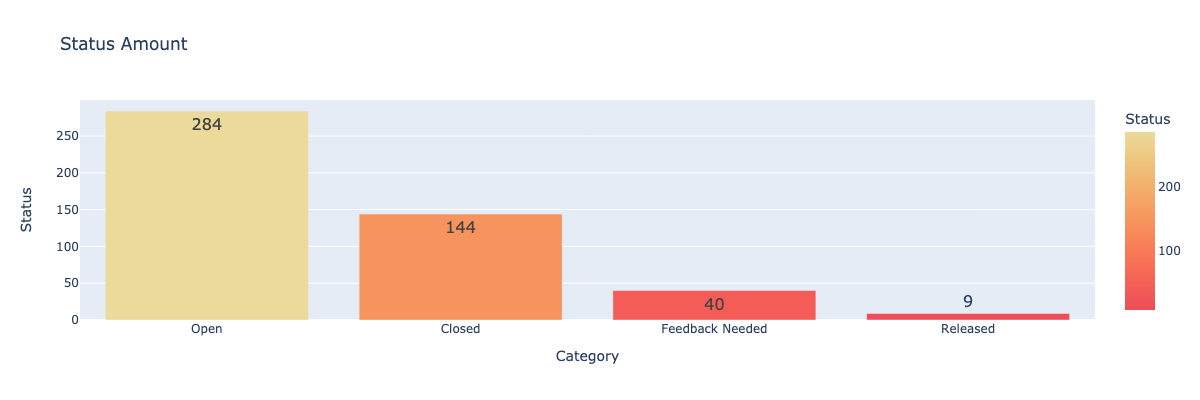

In [9]:

data_status = data['status'].value_counts().reset_index()
x_axis = data_status['index']

fig = px.bar(
    data_status,
    x='index',
    y='status',
    color='status',
    # color_continuous_scale=px.colors.sequential.Viridis,
    color_continuous_scale=str(px.colors.named_colorscales()[27])+'_r',
    width=1200,
    height=400,
    text_auto=True,
    title="Status Amount",
    labels={"index":"Category","status":"Status"},
)

fig.update_layout(xaxis={'categoryorder':'total descending'})

fig.update_traces(textfont_size=16)

fig.show('png')

In [10]:
# Top 10 (by vote count) features already implemented:
data[data.status=='Done'][:10].sort_values('votes', ascending=False)

,page,id,suggestion,author,date_created,last_upvoted,comments,status,votes,date_created_month


In [11]:
# Top 10 votes features not done:
data[data.status!='Done'].sort_values('votes', ascending=False)[:10]

,page,id,suggestion,author,date_created,last_upvoted,comments,status,votes,date_created_month
1,1,170983,Watch an ad to see a person who likes you,Anonymous,"19 Mar, 2021",yesterday,35.0,Feedback Needed,627.0,Mar
2,1,161962,Last onlinerecently active,Moses,"22 Feb, 2021",today,54.0,Feedback Needed,598.0,Feb
3,1,177816,Skip a profile save for later,Brian,"11 Apr, 2021",today,42.0,Feedback Needed,521.0,Apr
4,1,164928,Filter church activity,Moses,"01 Mar, 2021",30 Oct,47.0,Released,483.0,Mar
5,1,296565,Remove swipe limit,Sheppard,30 Apr,today,66.0,Feedback Needed,382.0,Apr
39,1,165279,Birthday surprise,Jefferson Glenn,"02 Mar, 2021",29 Oct,10.0,Open,288.0,Mar
40,1,161959,Filter has children or not,Moses,"22 Feb, 2021",13 Oct,29.0,Released,256.0,Feb
41,1,161947,Filter interest level,Moses,"22 Feb, 2021",19 Oct,39.0,Released,243.0,Feb
6,1,161000,Dark mode,Moses,"19 Feb, 2021",2 days ago,11.0,Feedback Needed,224.0,Feb
7,1,169459,Voice messaging,Johnson Daniel Kalu,"15 Mar, 2021",30 Oct,18.0,Feedback Needed,206.0,Mar
